Naming Explanation :
XXXYYZZZ
XXX - ID number of a person who has done the signature. 
YY - Image sample number.
ZZZ - ID number of person whose signature is in photo.

Example: 
NFI-00602023 is an image of signature of person number 023 done by person 006. This is a forged signature.
NFI-02103021 is an image of signature of person number 021 done by person 021. This is a genuine signature.   

In [5]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.filters import threshold_otsu

In [6]:
import git
repo = git.Repo('.', search_parent_directories=True)

In [7]:
#Define Path
forge_path = repo.working_tree_dir + "\\forge"
real_path = repo.working_tree_dir + "\\real"

In [8]:
#Preprocessing

def rgbToGray (img_path):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img_gray

def grayToBin(gray_img):

    blur_radius = 0.8
    img = ndimage.gaussian_filter(gray_img, blur_radius)

    thres = threshold_otsu(img)
    binimg = img > thres
    binimg = np.logical_not(binimg)
    return binimg

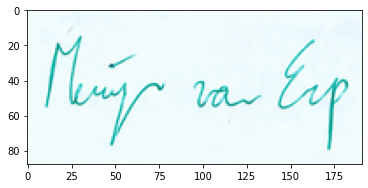

In [9]:
img_path = real_path + "\\00100001.png"
img = plt.imread(img_path)
plt.imshow(img)



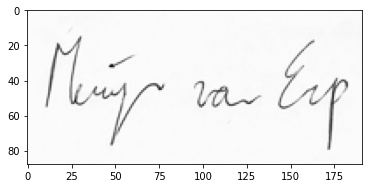

In [15]:
gray_img = rgbToGray(img_path)

plt.imshow(gray_img, cmap="Greys_r")   
# plt.imshow(gray_img, 'gray')    
# plt.imshow(gray_img) 

# cv2.imshow('image', gray_img)
# cv2.waitKey(5000)
# cv2.destroyAllWindows

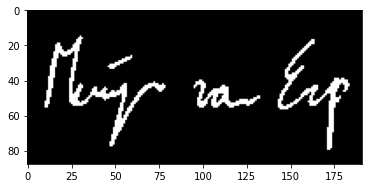

In [19]:
binary_img = grayToBin(gray_img)
plt.imshow(binary_img, 'gray')